<a href="https://colab.research.google.com/github/Faizanealiqazi/TSP_CUCKOO_SEARCH/blob/main/NIIA_PROJECT_EFFECTS_OF_POPULATION_ON_CUCKOO_SEARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.cm import get_cmap

In [2]:
"""
Possible Lévy distribution
Mantegna's Algorithm // Currently applied
Inverse Transform Sampling
Chambers-Mallows-Stuck Method (CMS)
Series Expansion
Monte Carlo Simulation
Fourier Transform Sampling
Rejection Sampling
"""

"\nPossible Lévy distribution\nMantegna's Algorithm // Currently applied\nInverse Transform Sampling\nChambers-Mallows-Stuck Method (CMS)\nSeries Expansion\nMonte Carlo Simulation\nFourier Transform Sampling\nRejection Sampling\n"

In [3]:
"""
Initialize population with random tours
Evaluate the fitness of each tour

for each generation do
    Generate a new tour by Lévy flight from an existing tour
    Evaluate its fitness
    Choose a random nest (tour) from the population
    if the fitness of the new tour is better than the chosen nest then
        Replace the chosen nest with the new tour
    end if
    Abandon a fraction pa of the worst nests and generate new ones
    Keep the best tour found so far
end for

Return the best tour
"""

'\nInitialize population with random tours\nEvaluate the fitness of each tour\n\nfor each generation do\n    Generate a new tour by Lévy flight from an existing tour\n    Evaluate its fitness\n    Choose a random nest (tour) from the population\n    if the fitness of the new tour is better than the chosen nest then\n        Replace the chosen nest with the new tour\n    end if\n    Abandon a fraction pa of the worst nests and generate new ones\n    Keep the best tour found so far\nend for\n\nReturn the best tour\n'

In [4]:
# 1. Sphere Function
def sphere(x):
    return sum([xi**2 for xi in x])

# 2. Rastrigin Function
def rastrigin(x):
    return 10 * len(x) + sum([(xi**2 - 10 * np.cos(2 * np.pi * xi)) for xi in x])

# 3. Ackley Function
def ackley(x):
    a, b, c = 20, 0.2, 2 * np.pi
    sum_sq_term = -a * np.exp(-b * np.sqrt(sum([xi**2 for xi in x]) / len(x)))
    cos_term = -np.exp(sum([np.cos(c * xi) for xi in x]) / len(x))
    return a + np.exp(1) + sum_sq_term + cos_term

# 4. Rosenbrock Function
def rosenbrock(x):
    return sum([100 * (x[i+1] - x[i]**2)**2 + (x[i] - 1)**2 for i in range(len(x)-1)])

# 5. Griewank Function
def griewank(x):
    part1 = sum([xi**2 / 4000 for xi in x])
    part2 = np.prod([np.cos(xi / np.sqrt(i+1)) for i, xi in enumerate(x)])
    return 1 + part1 - part2

# 6. Levy Function
def levy(x):
    w = 1 + (np.array(x) - 1) / 4
    term1 = np.sin(np.pi * w[0])**2
    term3 = (w[-1] - 1)**2 * (1 + np.sin(2 * np.pi * w[-1])**2)
    sum_terms = sum([(wi - 1)**2 * (1 + 10 * np.sin(np.pi * wi + 1)**2) for wi in w[:-1]])
    return term1 + sum_terms + term3

# 7. Schwefel Function
def schwefel(x):
    return 418.9829 * len(x) - sum([xi * np.sin(np.sqrt(abs(xi))) for xi in x])

# 8. De Jong's Function
def de_jong(x):
    return sum([xi**2 for xi in x])

# 9. Himmelblau's Function
def himmelblau(x):
    x, y = x[0], x[1]
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

# 10. Easom Function
def easom(x):
    x, y = x[0], x[1]
    return -np.cos(x) * np.cos(y) * np.exp(-(x - np.pi)**2 - (y - np.pi)**2)

# 11. Michalewicz Function
def michalewicz(x, m=10):
    return -sum([np.sin(xi) * np.sin((i + 1) * xi**2 / np.pi)**(2 * m) for i, xi in enumerate(x)])

# 12. Beale's Function
def beale(x):
    x1, x2 = x[0], x[1]
    return (1.5 - x1 + x1 * x2)**2 + (2.25 - x1 + x1 * x2**2)**2 + (2.625 - x1 + x1 * x2**3)**2

# 13. Goldstein-Price Function
def goldstein_price(x):
    x1, x2 = x[0], x[1]
    return (1 + (x1 + x2 + 1)**2 * (19 - 14 * x1 + 3 * x1**2 - 14 * x2 + 6 * x1 * x2 + 3 * x2**2)) * \
           (30 + (2 * x1 - 3 * x2)**2 * (18 - 32 * x1 + 12 * x1**2 + 48 * x2 - 36 * x1 * x2 + 27 * x2**2))

# 14. Booth's Function
def booth(x):
    x1, x2 = x[0], x[1]
    return (x1 + 2 * x2 - 7)**2 + (2 * x1 + x2 - 5)**2

# 15. Bukin Function N.6
def bukin(x):
    x1, x2 = x[0], x[1]
    return 100 * np.sqrt(abs(x2 - 0.01 * x1**2)) + 0.01 * abs(x1 + 10)

# 16. Matyas Function
def matyas(x):
    x1, x2 = x[0], x[1]
    return 0.26 * (x1**2 + x2**2) - 0.48 * x1 * x2

# 17. Three-hump Camel Function
def three_hump_camel(x):
    x1, x2 = x[0], x[1]
    return 2 * x1**2 - 1.05 * x1**4 + (x1**6 / 6) + x1 * x2 + x2**2

# 18. Six-hump Camel Function
def six_hump_camel(x):
    x1, x2 = x[0], x[1]
    return (4 - 2.1 * x1**2 + (x1**4 / 3)) * x1**2 + x1 * x2 + (-4 + 4 * x2**2) * x2**2

# 19. Cross-in-Tray Function
def cross_in_tray(x):
    x1, x2 = x[0], x[1]
    term = np.abs(100 - np.sqrt(x1**2 + x2**2) / np.pi)
    return -0.0001 * (np.abs(np.sin(x1) * np.sin(x2) * np.exp(term)) + 1)**0.1

# 20. Eggholder Function
def eggholder(x):
    x1, x2 = x[0], x[1]
    return -(x2 + 47) * np.sin(np.sqrt(abs(x2 + x1 / 2 + 47))) - x1 * np.sin(np.sqrt(abs(x1 - (x2 + 47))))

In [5]:
# Function to plot the initial configuration of the TSP
def plot_initial_tsp_graph(cities):
    plt.figure(figsize=(10, 6))
    plt.scatter(cities[:, 0], cities[:, 1], color='red')
    plt.title('Initial Traveling Salesman Problem Graph')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()

# Function to generate a random path
def random_path(num_cities):
    return np.random.permutation(num_cities)

def random_path_with_fixed_start(num_cities, start_city=0):
    path = np.random.permutation(num_cities)
    start_index = np.where(path == start_city)[0][0]
    path[0], path[start_index] = path[start_index], path[0]
    return path

# Function to calculate total distance of a path
def total_distance(cities, path):
    return sum(np.linalg.norm(cities[path[i]] - cities[path[(i + 1) % len(path)]]) for i in range(len(path)))

# Levy flight function (Mantegna's Algorithm) for TSP
def levy_flight(beta, size=1):
    # Calculation of sigma (standard deviation)
    sigma_u = (math.gamma(1 + beta) * math.sin(math.pi * beta / 2) /
               (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    sigma_v = 1

    u = np.random.normal(0, sigma_u, size)
    v = np.random.normal(0, sigma_v, size)
    step = u / np.fabs(v) ** (1 / beta)

    return step

# Cuckoo Search for TSP with simple Lévy flights
def cuckoo_search_tsp(cities, nests, fitness, n, max_iter, pa, beta=1.5):
    num_cities = len(cities)

    # Subsample nests for the current population size
    current_nests = nests[:n]
    current_fitness = fitness[:n]

    # Find the best solution in the initial population
    best_nest_idx = current_fitness.argmin()
    best_nest = current_nests[best_nest_idx]
    best_fitness = current_fitness[best_nest_idx]

    for iter in range(max_iter):
        for i in range(n):
            new_nest = np.copy(nests[i])

            # Get a step size from Lévy flight
            step_size = levy_flight(beta)
            # Apply the step to a randomly chosen subset of the tour
            city_indices = np.sort(np.random.choice(num_cities, 2, replace=False))
            start, end = city_indices
            if (start + step_size) % num_cities < end:
                new_nest[start:end] = np.roll(new_nest[start:end], int(step_size))
            else:
                new_nest[end:(start + int(step_size)) % num_cities] = np.roll(new_nest[end:(start + int(step_size)) % num_cities], int(step_size))

            # Calculate the fitness of the new solution
            fnew = total_distance(cities, new_nest)

            # Greedily select the better solution
            if fnew < fitness[i]:
                nests[i] = new_nest
                fitness[i] = fnew

                # Update the best solution found so far
                if fnew < best_fitness:
                    best_nest = new_nest
                    best_fitness = fnew

        # Abandon a fraction (pa) of the worst nests
        for i in range(n):
            if np.random.rand() < pa:
                nests[i] = random_path(num_cities)  # Generate a new random solution for a nest
                fitness[i] = total_distance(cities, nests[i])  # Recalculate its fitness

    return best_nest, best_fitness


def run_cuckoo_search(cities, population_sizes, max_iter, pa, max_nests=100, num_runs=1):
    num_cities = len(cities)

    all_nests = [random_path(num_cities) for _ in range(max_nests)]
    all_fitness = np.array([total_distance(cities, nest) for nest in all_nests])

    avg_distances = []
    best_distances = []
    best_paths = []
    for n in population_sizes:
        distances = []
        for _ in range(num_runs):
            best_path, best_fitness = cuckoo_search_tsp(cities, all_nests, all_fitness, n, max_iter, pa)
            distances.append(best_fitness)
            best_distances.append(best_fitness)


        best_paths.append(best_path)
        avg_distance = sum(distances) / len(distances)
        avg_distances.append(avg_distance)
        print(f"Population size: {n}, Average Distance: {avg_distance}")

    return best_distances, best_paths, avg_distances


# Function to find the best population size
def test_population_sizes(cities, population_sizes, max_iter, pa, best_distances):
    best_index = np.argmin(best_distances)
    best_population_size = population_sizes[best_index]
    best_distance = best_distances[best_index]
    return best_population_size, best_distance

# Function to plot the effect of population size on the Cuckoo Search performance
def test_population_sizes_plot(population_sizes, best_distances):
    plt.figure(figsize=(10, 6))
    plt.plot(population_sizes, best_distances, marker='o')
    plt.title('Effect of Population Size on Cuckoo Search for TSP')
    plt.xlabel('Population Size')
    plt.ylabel('Best Distance Found')
    plt.grid(True)
    plt.show()


def plot_best_paths(cities, best_paths, best_index=None, plot_best_flag_only=True):
    num_paths = len(best_paths)
    #Generating a color map
    cmap = get_cmap('viridis', num_paths)

    # Filtering to only plot the best path if flag is set
    paths_to_plot = [best_paths[best_index]] if plot_best_flag_only and best_index is not None else best_paths

    for i, best_path in enumerate(paths_to_plot):
        plt.figure(figsize=(12, 8))
        plt.scatter(cities[:, 0], cities[:, 1], color='red', zorder=5)
        color = cmap(i)
        for j in range(len(best_path)):
            start_city = cities[best_path[j]]
            end_city = cities[best_path[(j + 1) % len(best_path)]]
            plt.plot([start_city[0], end_city[0]], [start_city[1], end_city[1]], color=color, zorder=1)
            # Annotating the city with the order number if not plotting the best path only
            plt.annotate(f'{j}', (start_city[0], start_city[1]), textcoords="offset points", xytext=(0,10), ha='center', zorder=10)

        plt.title('Best Path Found by Cuckoo Search' if plot_best_flag_only else 'Best Paths Found by Cuckoo Search for Different Population Sizes')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.grid(True)
        plt.show()


In [6]:
num_cities = 100
max_iter = 1000
pa = 0.25
population_sizes = [20, 40, 80, 100]  # Different population sizes to test
cities = np.random.rand(num_cities, 2)

In [15]:
#Function to run with default parameters
def run(num_cities=100, population_sizes=[20, 40, 80, 100], cities=[], max_iter=1000, pa=0.25, num_runs=1):
  if len(cities)==0:
    cities = np.random.rand(num_cities, 2)

  #Plot the initial TSP graph
  plot_initial_tsp_graph(cities)

  #Run the Cuckoo Search algorithm for different population sizes
  best_distances, best_paths, avg_distances = run_cuckoo_search(cities, population_sizes, max_iter, pa, max(population_sizes), num_runs)

  #Find the best population size based on the best distances obtained
  best_population_size, best_distance = test_population_sizes(cities, population_sizes, max_iter, pa, best_distances)
  print(f"The best population size is {best_population_size} with a distance of {best_distance}.")

  #Plot the effect of population size on the Cuckoo Search performance
  test_population_sizes_plot(population_sizes, avg_distances)

  #Retrieve the best path for the best population size
  best_index = population_sizes.index(best_population_size)
  best_path = best_paths[best_index]

  #Space
  print("")

  #Plot best paths for each population size
  plot_best_paths(cities, best_paths, best_index)

cities: [[0.20977742 0.51339207]
 [0.70806906 0.41296835]
 [0.35252836 0.24155852]
 [0.62776522 0.39298538]
 [0.86833331 0.72629698]
 [0.65002947 0.24560094]
 [0.89203079 0.5667974 ]
 [0.43394396 0.94789798]
 [0.37896244 0.32867587]
 [0.31545464 0.33593273]
 [0.85347273 0.10839117]
 [0.84564733 0.83675728]
 [0.87575556 0.24646122]
 [0.36162833 0.95723491]
 [0.34392041 0.6511969 ]
 [0.45735407 0.48252728]
 [0.71594776 0.26786855]
 [0.22115162 0.63979749]
 [0.7126589  0.24002572]
 [0.47461879 0.84622577]
 [0.91261762 0.52696565]
 [0.86497756 0.1330027 ]
 [0.83706238 0.42063212]
 [0.14310359 0.97842584]
 [0.7350398  0.69563272]
 [0.93194204 0.50677169]
 [0.07721767 0.3839176 ]
 [0.61770069 0.79735802]
 [0.50283223 0.6101631 ]
 [0.55029596 0.98986467]
 [0.9445425  0.22403558]
 [0.85660008 0.57216089]
 [0.53968745 0.26307631]
 [0.00905128 0.54415806]
 [0.18835413 0.13869642]
 [0.95248655 0.12315466]
 [0.18210997 0.05347174]
 [0.29789778 0.81956709]
 [0.3743108  0.08586525]
 [0.19821553 0.88

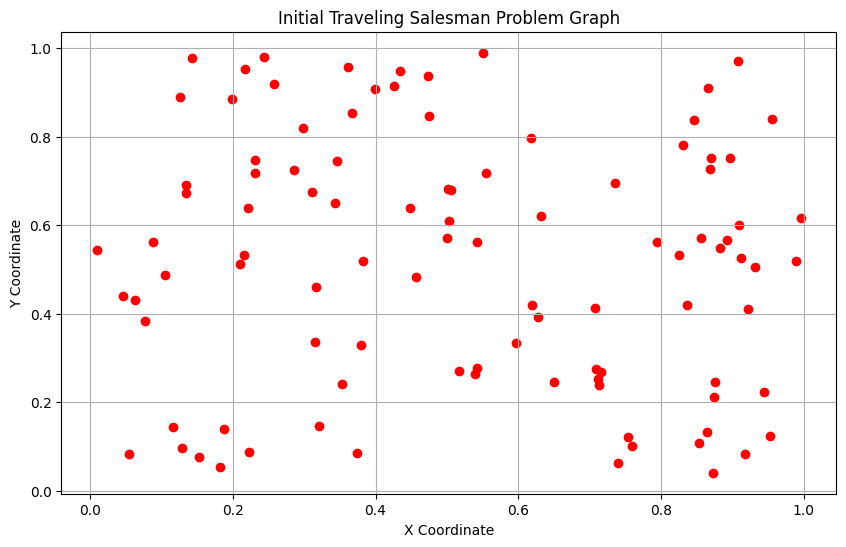

Population size: 20, Average Distance: 43.74740516489398
Population size: 40, Average Distance: 42.7955369352084
Population size: 80, Average Distance: 43.221407405351826
Population size: 100, Average Distance: 42.0362062566199
The best population size is 100 with a distance of 42.0362062566199.


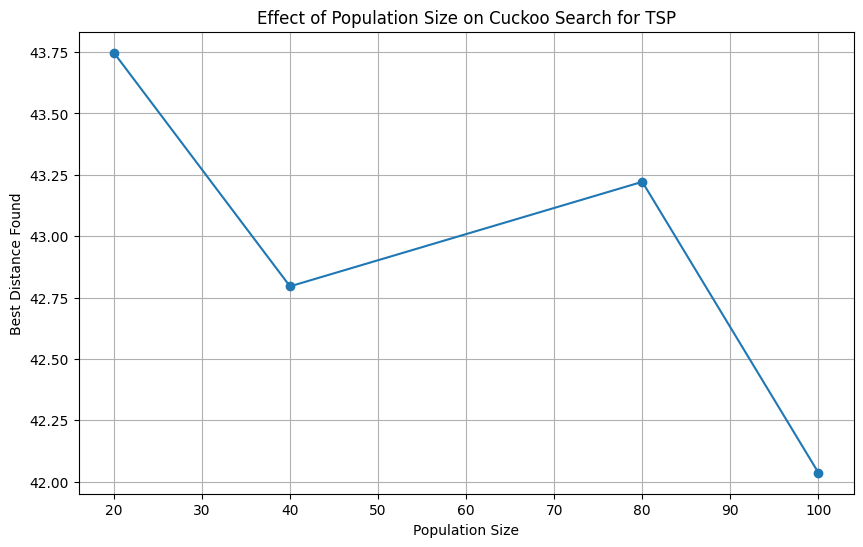

<ipython-input-5-ca95464cc47f>:133: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis', num_paths)


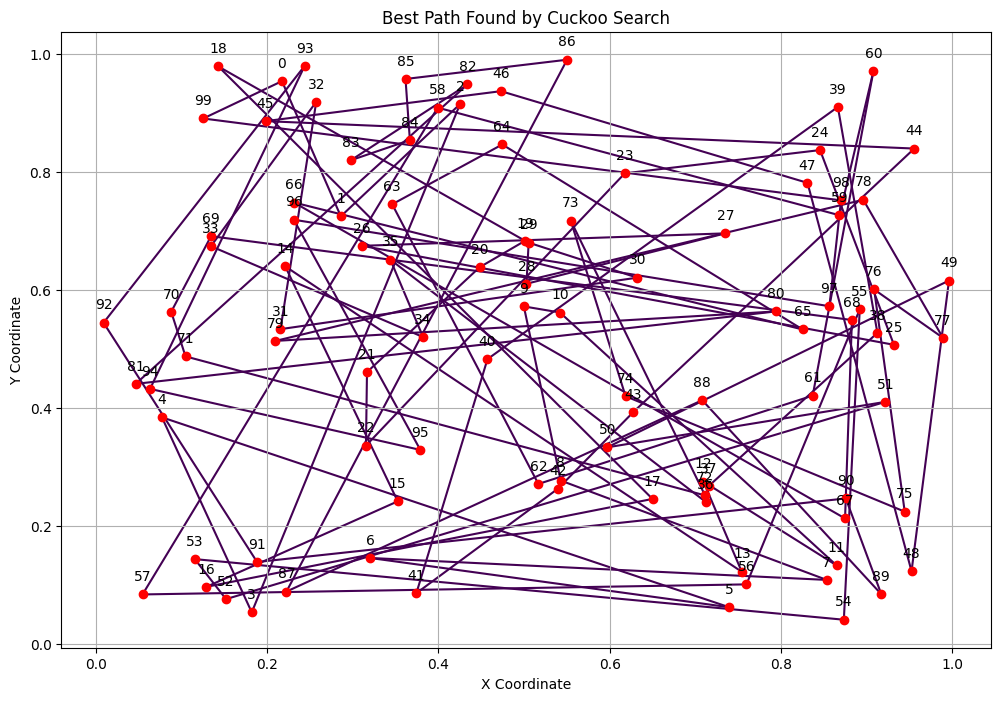

In [16]:
run()